In [10]:
!pip install --quiet openai beautifulsoup4 requests pillow selectolax


[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [11]:
# --- Imports ---
import os
import time
import json
import random
import requests
from bs4 import BeautifulSoup
from IPython.display import display, Image as IPyImage, Markdown, HTML
from openai import OpenAI
from io import BytesIO
from functools import lru_cache

# --- Config ---
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
if not OPENAI_API_KEY:
    raise RuntimeError("Please set your OPENAI_API_KEY environment variable before running.")
client = OpenAI(api_key=OPENAI_API_KEY)

# --- Utility: Display Markdown nicely ---
def show_title(text): display(Markdown(f"## {text}"))
def show_subtitle(text): display(Markdown(f"### {text}"))
def show_codeblock(text): display(Markdown(f"```json\n{text}\n```"))

# ---------------------------------------------------------------------
# 🧩 STEP 1: PROMPT UNDERSTANDING
# ---------------------------------------------------------------------
def extract_intent(prompt: str) -> dict:
    """
    Use LLM to analyze the prompt and extract structured intent.
    Output: modality, domain, subject, context, style, realism_score, abstractness_score
    """
    system_msg = (
        "You are a reasoning model that extracts structured details from a prompt for a media search system. "
        "Return ONLY valid JSON with the following fields: "
        "modality, domain, subject, context, style, realism_score (0-1), abstractness_score (0-1)."
    )
    resp = client.chat.completions.create(
        model="gpt-4o-mini",
        messages=[
            {"role": "system", "content": system_msg},
            {"role": "user", "content": f"Prompt: {prompt}"}
        ],
        temperature=0.2,
        max_tokens=250
    )
    content = resp.choices[0].message.content
    try:
        return json.loads(content)
    except Exception:
        start, end = content.find("{"), content.rfind("}")
        if start != -1 and end != -1:
            try:
                return json.loads(content[start:end+1])
            except:
                pass
        return {"modality":"image","domain":"unknown","subject":prompt,"context":"","style":"",
                "realism_score":0.5,"abstractness_score":0.5}

# ---------------------------------------------------------------------
# 🧩 STEP 2: DECISION REASONING
# ---------------------------------------------------------------------
def decide_fetch_or_generate(feasibility: dict) -> str:
    """
    Decide FETCH vs GENERATE.
    """
    decision_prompt = (
        "You are a decision engine. Based on the following JSON, respond only with FETCH or GENERATE.\n\n"
        f"{json.dumps(feasibility)}"
    )
    resp = client.chat.completions.create(
        model="gpt-4o-mini",
        messages=[{"role": "user", "content": decision_prompt}],
        temperature=0.0,
        max_tokens=5,
    )
    decision = resp.choices[0].message.content.strip().upper()
    if "FETCH" in decision:
        return "FETCH"
    elif "GENERATE" in decision:
        return "GENERATE"
    return "FETCH" if feasibility.get("realism_score", 0.5) > 0.6 else "GENERATE"

# ---------------------------------------------------------------------
# 🧩 STEP 3: SCRAPING FROM UNSPLASH
# ---------------------------------------------------------------------
import requests, time, random
from functools import lru_cache

HEADERS = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64)"
                  " AppleWebKit/537.36 (KHTML, like Gecko)"
                  " Chrome/120.0 Safari/537.36"
}

@lru_cache(maxsize=10)
def scrape_unsplash(query: str, limit=6, delay_range=(1, 2)):
    """
    Scrape Unsplash's public JSON API for photo URLs.
    Uses no API key. Observes best practices with headers and randomized delays.
    """
    print(f"🔎 Searching Unsplash for: '{query}'")
    time.sleep(random.uniform(*delay_range))
    url = f"https://unsplash.com/napi/search/photos?query={query.replace(' ', '+')}&per_page={limit}&page=1"
    res = requests.get(url, headers=HEADERS)

    if res.status_code != 200:
        print(f"⚠️ Unsplash returned status {res.status_code}")
        return []

    data = res.json()
    urls = [p["urls"]["small"] for p in data.get("results", []) if "urls" in p]

    if not urls:
        print("⚠️ No results found.")
    return urls

def show_images(urls, title="Fetched Results"):
    show_subtitle(title)
    if not urls:
        print("No images found.")
        return
    html = "".join([f'<img src="{u}" width="200" style="margin:4px;border-radius:8px;">' for u in urls])
    display(HTML(html))

# ---------------------------------------------------------------------
# 🧩 STEP 4: FULL PIPELINE (LLM + SCRAPER)
# ---------------------------------------------------------------------
def media_fetching_pipeline(prompt: str):
    show_title(f"Prompt: *{prompt}*")

    # Step 1: Understand prompt
    show_subtitle("Step 1: Extracting intent from prompt...")
    feasibility = extract_intent(prompt)
    show_codeblock(json.dumps(feasibility, indent=2))

    # Step 2: Decision Reasoning
    show_subtitle("Step 2: Decision Reasoning...")
    decision = decide_fetch_or_generate(feasibility)
    print(f"🤖 LLM Decision → {decision}")

    # Step 3: Scraping if FETCH
    if decision == "FETCH":
        subject = feasibility.get("subject") or prompt
        urls = scrape_unsplash(subject)
        show_images(urls, "Step 3: Unsplash Scraped Images")
    else:
        show_subtitle("Step 3: Generation (Not Implemented Yet)")
        print("Will use image generation model later (e.g., gpt-image-1 or Stable Diffusion).")

    print("\n✅ Pipeline completed.\n")

# ---------------------------------------------------------------------
# 🧩 DEMO RUNS
# ---------------------------------------------------------------------
show_title("🧠 MEDIA FETCHING DEMO — UNSPLASH SCRAPING PIPELINE")

# Case 1 → Realistic prompt
media_fetching_pipeline("A smiling doctor standing in a hospital hallway")

# Case 2 → Fantasy prompt
media_fetching_pipeline("A glowing dragon flying above a crystal castle at sunset")

# Case 3 → Object prompt
media_fetching_pipeline("Close-up shot of a vintage camera on a wooden table")


## 🧠 MEDIA FETCHING DEMO — UNSPLASH SCRAPING PIPELINE

## Prompt: *A smiling doctor standing in a hospital hallway*

### Step 1: Extracting intent from prompt...

```json
{
  "modality": "image",
  "domain": "healthcare",
  "subject": "doctor",
  "context": "hospital hallway",
  "style": "realistic",
  "realism_score": 0.9,
  "abstractness_score": 0.1
}
```

### Step 2: Decision Reasoning...

🤖 LLM Decision → FETCH
🔎 Searching Unsplash for: 'doctor'
⚠️ Unsplash returned status 403


### Step 3: Unsplash Scraped Images

No images found.

✅ Pipeline completed.



## Prompt: *A glowing dragon flying above a crystal castle at sunset*

### Step 1: Extracting intent from prompt...

```json
{
  "modality": "visual",
  "domain": "fantasy",
  "subject": "dragon",
  "context": "flying above a castle",
  "style": "fantasy art",
  "realism_score": 0.2,
  "abstractness_score": 0.3
}
```

### Step 2: Decision Reasoning...

🤖 LLM Decision → GENERATE


### Step 3: Generation (Not Implemented Yet)

Will use image generation model later (e.g., gpt-image-1 or Stable Diffusion).

✅ Pipeline completed.



## Prompt: *Close-up shot of a vintage camera on a wooden table*

### Step 1: Extracting intent from prompt...

```json
{
  "modality": "image",
  "domain": "photography",
  "subject": "vintage camera",
  "context": "wooden table",
  "style": "close-up",
  "realism_score": 0.9,
  "abstractness_score": 0.1
}
```

### Step 2: Decision Reasoning...

🤖 LLM Decision → FETCH
🔎 Searching Unsplash for: 'vintage camera'
⚠️ Unsplash returned status 403


### Step 3: Unsplash Scraped Images

No images found.

✅ Pipeline completed.



In [12]:
print(res.status_code, res.text[:300])


NameError: name 'res' is not defined

In [ ]:
import os
from httpx import get
from selectolax.parser import HTMLParser
from urllib.parse import urlparse, urlunparse

# Function to save images
def save_images(img_urls, dest_dir="images", tag=""):
    if not os.path.exists(dest_dir):
        os.makedirs(dest_dir)
    
    successful_downloads = 0  # Counter for successful downloads
    
    for url in img_urls:
        resp = get(url)
        if resp.status_code == 200:
            file_name = url.split("/")[-1]
            with open(os.path.join(dest_dir, f"{tag}{file_name}.jpg"), "wb") as file:
                file.write(resp.content)
            successful_downloads += 1  # Increment counter for successful downloads
    
    return successful_downloads  # Return the count of successful downloads

# Fetching and filtering image URLs
url = "https://unsplash.com/s/photos/galaxy"
resp = get(url)

if resp.status_code != 200:
    raise Exception("Error getting response")

tree = HTMLParser(resp.text)
images_with_srcset = tree.css("figure a img[srcset]")

exclude_words = ["data:", "profile", "premium"]
filtered_urls_without_params = []

for img in images_with_srcset:
    srcset = img.attrs.get("srcset", "")
    urls = srcset.split(", ")
    
    for u in urls:
        if any(exclude_word in u for exclude_word in exclude_words):
            continue  # Skip the url containing any of the exclude words

        parsed_url = urlparse(u.split(" ")[0])
        clean_url = urlunparse((parsed_url.scheme, parsed_url.netloc, parsed_url.path, '', '', ''))
        if clean_url not in filtered_urls_without_params:
            filtered_urls_without_params.append(clean_url)

# Download the images and get the count of successful downloads
successful_downloads_count = save_images(filtered_urls_without_params)

# Feedback message
print(f"Successfully downloaded {successful_downloads_count} images.")

Exception: Error getting response


🔍 Found 12 image URLs for 'dancing girl'. Downloading...

✅ Downloaded unsplash_scrape_downloads\img_1.jpg
✅ Downloaded unsplash_scrape_downloads\img_2.jpg
✅ Downloaded unsplash_scrape_downloads\img_3.jpg
✅ Downloaded unsplash_scrape_downloads\img_4.jpg
✅ Downloaded unsplash_scrape_downloads\img_5.jpg
✅ Downloaded unsplash_scrape_downloads\img_6.jpg
✅ Downloaded unsplash_scrape_downloads\img_7.jpg
❌ Failed https://images.unsplash.com/photo-1682760631807-71067eeea033?ixlib=rb-4.1.0&ixid=M3wxMjA3fDB8MHxzZWFyY2h8OHx8ZGFuY2luZyUyMGdpcmx8ZW58MHx8MHx8fDA%3D&auto=format&fit=crop&q=60&w=2000: ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))
✅ Downloaded unsplash_scrape_downloads\img_9.jpg
✅ Downloaded unsplash_scrape_downloads\img_10.jpg
✅ Downloaded unsplash_scrape_downloads\img_11.jpg
✅ Downloaded unsplash_scrape_downloads\img_12.jpg

✅ Downloaded 11 images. Displaying them now...


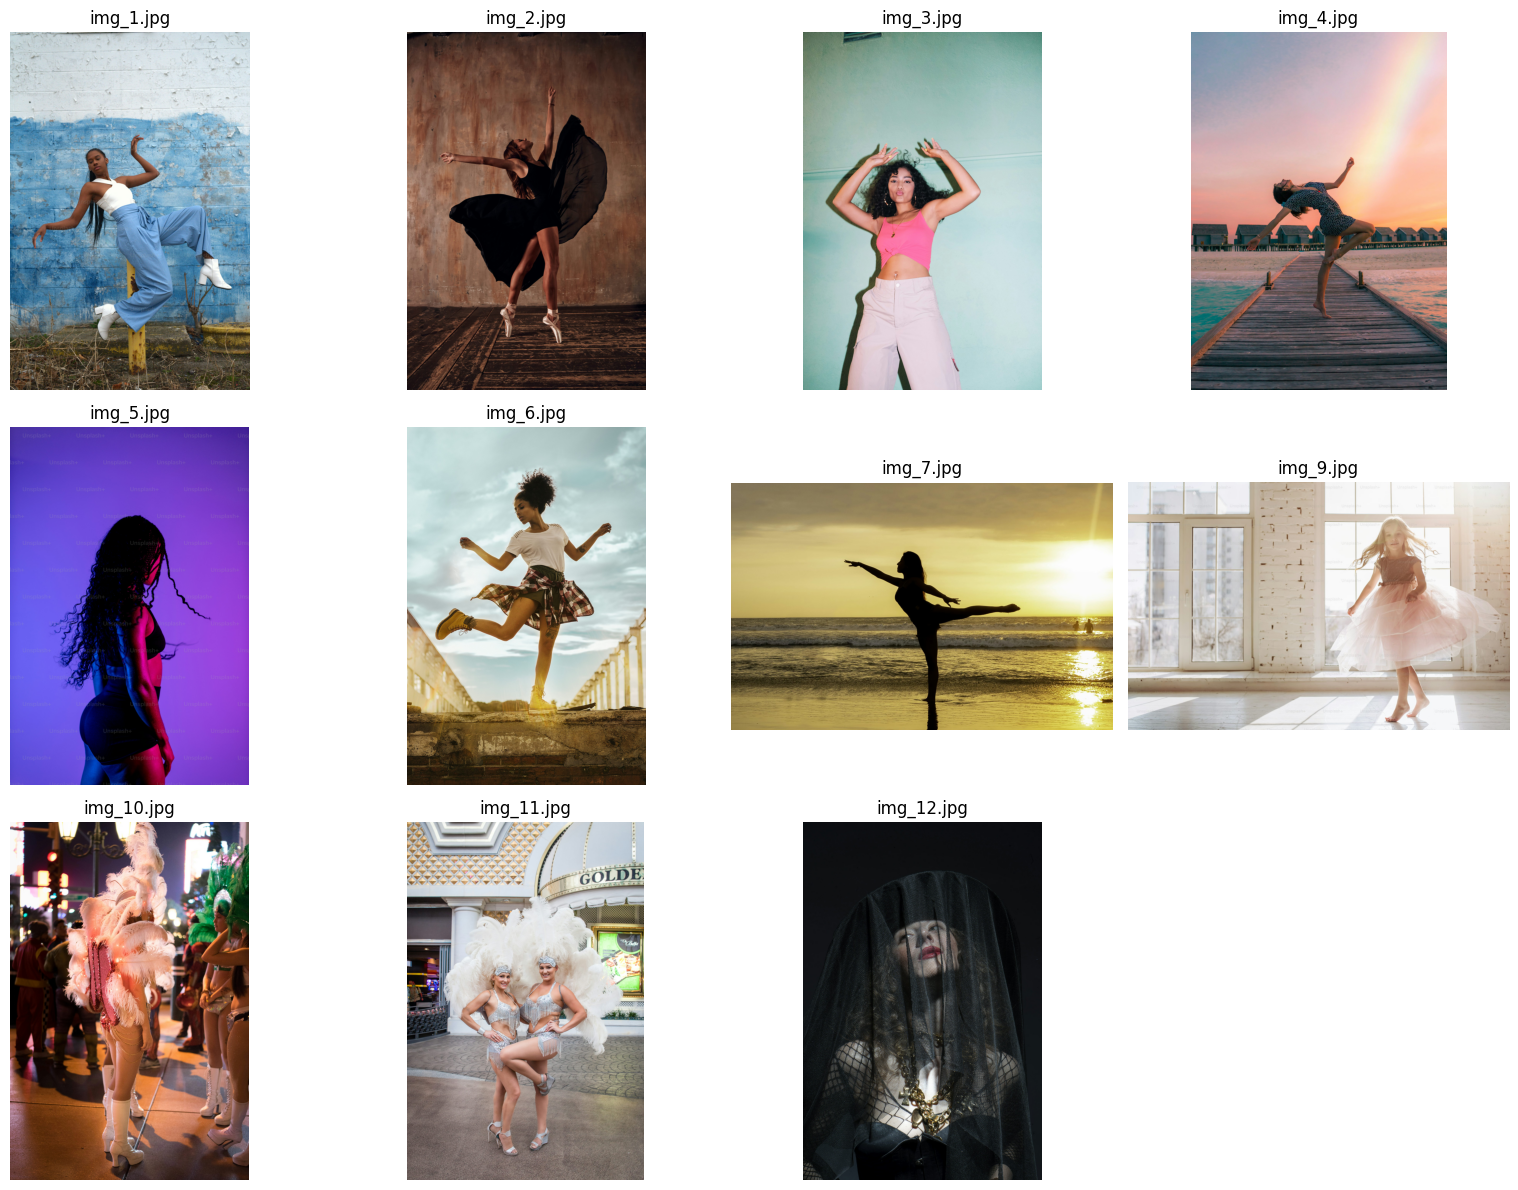

In [20]:
# requirements:
# pip install selenium webdriver-manager requests matplotlib pillow
# (This script uses webdriver-manager to auto-download chromedriver)

import os, time, requests
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from webdriver_manager.chrome import ChromeDriverManager
import matplotlib.pyplot as plt
from PIL import Image

DEST_DIR = "unsplash_scrape_downloads"
os.makedirs(DEST_DIR, exist_ok=True)

# -----------------------------
# Create WebDriver
# -----------------------------
def create_driver(headless=False):
    chrome_options = Options()
    if headless:
        chrome_options.add_argument("--headless=new")
    chrome_options.add_argument("--no-sandbox")
    chrome_options.add_argument("--disable-dev-shm-usage")
    chrome_options.add_argument(
        "user-agent=Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/120 Safari/537.36"
    )

    service = Service(ChromeDriverManager().install())
    driver = webdriver.Chrome(service=service, options=chrome_options)
    driver.set_page_load_timeout(40)
    return driver


# -----------------------------
# Scroll and collect image URLs
# -----------------------------
import re
from PIL import Image
from io import BytesIO

# Helper: returns best candidate URL from src/srcset, preferring large srcset entry
import re
from PIL import Image
from io import BytesIO

# Helper: returns best candidate URL from src/srcset, preferring large srcset entry
def choose_best_image_src(src, srcset):
    # prefer srcset last item if available
    if srcset:
        try:
            parts = [p.strip() for p in srcset.split(",") if p.strip()]
            # take last entry (largest)
            last = parts[-1]
            url = last.split(" ")[0]
            return url
        except Exception:
            pass
    return src

# Helper: quick color variance check to skip logos/placeholders (optional)
def has_sufficient_color_variance(img_bytes, min_variance=200):
    try:
        im = Image.open(BytesIO(img_bytes)).convert("L")  # grayscale
        arr = list(im.getdata())
        # compute simple variance-ish metric: stdev approx via variance
        mean = sum(arr) / len(arr)
        var = sum((p - mean) ** 2 for p in arr) / len(arr)
        return var >= min_variance
    except Exception:
        return True  # if can't compute, assume ok

def scroll_and_collect_image_urls(driver, search_query, max_images=20, scroll_pause=1.2, check_alt=True):
    url = f"https://unsplash.com/s/photos/{search_query.replace(' ', '-')}"
    driver.get(url)
    time.sleep(2)

    image_urls = []
    seen = set()
    last_height = driver.execute_script("return document.body.scrollHeight")
    query_words = [w.lower() for w in search_query.split()]

    while len(image_urls) < max_images:
        imgs = driver.find_elements(By.TAG_NAME, "img")
        for img in imgs:
            try:
                src = img.get_attribute("src") or ""
                srcset = img.get_attribute("srcset") or ""
                alt = (img.get_attribute("alt") or "").lower()
                aria = (img.get_attribute("aria-label") or "").lower()

                best = choose_best_image_src(src, srcset)
                if not best:
                    continue

                # Normalize URL by removing tracking params only if necessary (but keep size params later)
                best_clean = best.split("?")[0]

                # Heuristic 1: Accept only images from images.unsplash.com (most photos) OR urls containing '/photos/' or '/photo-'
                is_unsplash_photo = ("images.unsplash.com" in best) or ("/photos/" in best) or ("photo-" in best)

                if not is_unsplash_photo:
                    # skip non-unsplash images (site UI assets, avatars, logos)
                    continue

                # Heuristic 2: Check alt/aria contains any of the query words (makes it relevant)
                matched_alt = False
                if check_alt:
                    text_source = alt + " " + aria
                    for w in query_words:
                        if w in text_source:
                            matched_alt = True
                            break
                else:
                    matched_alt = True

                if not matched_alt:
                    # If alt doesn't match, we still allow if url path includes 'photo-' and not a tiny thumbnail
                    if "photo-" not in best and "/photos/" not in best:
                        continue

                # Heuristic 3: deduplicate final cleaned url and prefer the one with query params removed only for dedupe key
                dedupe_key = best_clean
                if dedupe_key in seen:
                    continue

                # Optional: quickly HEAD request to ensure we get a real image and filter tiny ones (avoids downloading placeholders)
                try:
                    headers = {"User-Agent": "Mozilla/5.0"}
                    resp = requests.head(best, headers=headers, timeout=8, allow_redirects=True)
                    ctype = resp.headers.get("content-type", "")
                    clength = resp.headers.get("content-length")
                    if not ctype.startswith("image"):
                        continue
                    if clength and int(clength) < 5_000:  # skip extremely tiny images (< ~5 KB)
                        continue
                except Exception:
                    # ignore HEAD failures and proceed — fallback will handle later on download
                    pass

                # Accept: add URL (prefer full URL with params so we can request size later)
                seen.add(dedupe_key)
                image_urls.append(best)
                if len(image_urls) >= max_images:
                    break

            except Exception:
                continue

        # scroll down
        driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
        time.sleep(scroll_pause)
        new_height = driver.execute_script("return document.body.scrollHeight")
        if new_height == last_height:
            break
        last_height = new_height

    return image_urls[:max_images]


# -----------------------------
# Download images
# -----------------------------
def download_images(urls):
    downloaded_files = []
    for idx, url in enumerate(urls, 1):
        try:
            fname = os.path.join(DEST_DIR, f"img_{idx}.jpg")
            headers = {"User-Agent": "Mozilla/5.0"}
            r = requests.get(url, headers=headers, stream=True, timeout=30)
            r.raise_for_status()
            with open(fname, "wb") as f:
                for chunk in r.iter_content(10240):
                    if chunk:
                        f.write(chunk)
            downloaded_files.append(fname)
            print(f"✅ Downloaded {fname}")
            time.sleep(0.3)
        except Exception as e:
            print(f"❌ Failed {url}: {e}")
    return downloaded_files


# -----------------------------
# Display downloaded images
# -----------------------------
def display_images(image_files):
    count = len(image_files)
    cols = 4
    rows = (count + cols - 1) // cols
    plt.figure(figsize=(16, rows * 4))

    for i, file in enumerate(image_files, 1):
        img = Image.open(file)
        plt.subplot(rows, cols, i)
        plt.imshow(img)
        plt.axis("off")
        plt.title(os.path.basename(file))
    plt.tight_layout()
    plt.show()


# -----------------------------
# Main
# -----------------------------
if __name__ == "__main__":
    query = "dancing girl"  # change search keyword here
    driver = create_driver(headless=True)

    try:
        urls = scroll_and_collect_image_urls(driver, query, max_images=12)
        print(f"\n🔍 Found {len(urls)} image URLs for '{query}'. Downloading...\n")
        downloaded = download_images(urls)
        print(f"\n✅ Downloaded {len(downloaded)} images. Displaying them now...")
        display_images(downloaded)

    finally:
        driver.quit()


In [25]:
!pip install selenium webdriver-manager requests python-dotenv pillow matplotlib



[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
"""
pinterest_scraper.py

Features:
- Optional login (use env vars PINTEREST_EMAIL and PINTEREST_PASSWORD or skip)
- Robust extraction of pin images (img tags, srcset, and background-image)
- Scrolling / lazy-load handling
- Downloads images and saves metadata to metadata.json
- Optional display of thumbnails (matplotlib + Pillow)

Usage:
- Edit the `QUERY` or `PAGE_URL` at the bottom, then run:
    python pinterest_scraper.py
"""

import os
import time
import json
import re
import requests
from io import BytesIO
from dotenv import load_dotenv
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
from webdriver_manager.chrome import ChromeDriverManager
from selenium.common.exceptions import NoSuchElementException
from PIL import Image, ImageOps
import matplotlib.pyplot as plt

load_dotenv()

# -----------------------
# Config
# -----------------------
DEST_DIR = "pinterest_downloads"
os.makedirs(DEST_DIR, exist_ok=True)
METADATA_FILE = os.path.join(DEST_DIR, "metadata.json")
USER_AGENT = "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/120 Safari/537.36"

PINTEREST_EMAIL = os.getenv("PINTEREST_EMAIL")
PINTEREST_PASSWORD = os.getenv("PINTEREST_PASSWORD")

# Tweak these values
MAX_PINS = 40
SCROLL_PAUSE = 1.5
HEADLESS = False   # Set to True after debugging, but if you see blank results, run with False
MAX_SCROLLS = 80

# -----------------------
# Helpers / Driver
# -----------------------
def create_driver(headless=HEADLESS):
    opts = Options()
    if headless:
        # modern headless flag
        opts.add_argument("--headless=new")
    opts.add_argument("--no-sandbox")
    opts.add_argument("--disable-dev-shm-usage")
    opts.add_argument(f"user-agent={USER_AGENT}")
    # try to make detection harder
    opts.add_argument("--disable-blink-features=AutomationControlled")
    opts.add_experimental_option("excludeSwitches", ["enable-automation"])
    opts.add_experimental_option('useAutomationExtension', False)
    service = Service(ChromeDriverManager().install())
    driver = webdriver.Chrome(service=service, options=opts)
    driver.set_page_load_timeout(60)
    return driver

# -----------------------
# Optional login
# -----------------------
def pinterest_login(driver, email, password):
    if not email or not password:
        print("[login] No credentials found in env — skipping login.")
        return False
    try:
        driver.get("https://www.pinterest.com/login/")
        time.sleep(2)
        # Elements may vary; attempt common selectors
        try:
            email_input = driver.find_element(By.NAME, "id")
            pw_input = driver.find_element(By.NAME, "password")
        except NoSuchElementException:
            # fallback selectors
            email_input = driver.find_element(By.CSS_SELECTOR, "input[type='email']")
            pw_input = driver.find_element(By.CSS_SELECTOR, "input[type='password']")

        email_input.clear()
        email_input.send_keys(email)
        pw_input.clear()
        pw_input.send_keys(password)

        submit_btn = driver.find_element(By.XPATH, "//button[@type='submit' or contains(., 'Continue') or contains(., 'Log in')]")
        submit_btn.click()
        time.sleep(5)
        # simple check
        if "login" in driver.current_url.lower():
            print("[login] Still on login page — login may have failed or require captcha.")
            return False
        print("[login] Login appears successful (or bypassed).")
        return True
    except Exception as e:
        print("[login] Exception while logging in:", e)
        return False

# -----------------------
# Cookie / consent accept
# -----------------------
def accept_cookie_banner(driver):
    # tries multiple common button texts
    texts = ["Accept", "I agree", "Allow essential and optional", "Accept all", "Got it"]
    for t in texts:
        try:
            btn = driver.find_element(By.XPATH, f"//button[contains(translate(., 'ABCDEFGHIJKLMNOPQRSTUVWXYZ', 'abcdefghijklmnopqrstuvwxyz'), '{t.lower()}')]")
            btn.click()
            print("[consent] Clicked accept/consent button.")
            time.sleep(1)
            return True
        except Exception:
            continue
    return False

# -----------------------
# srcset helper
# -----------------------
def pick_from_srcset(srcset):
    if not srcset:
        return ""
    try:
        parts = [p.strip() for p in srcset.split(",") if p.strip()]
        # last is usually largest
        last = parts[-1]
        url = last.split(" ")[0]
        return url
    except Exception:
        return ""

# -----------------------
# Robust extractor
# -----------------------
def extract_pins_from_page(driver, max_pins=MAX_PINS, scroll_pause=SCROLL_PAUSE, max_scrolls=MAX_SCROLLS):
    pins = []
    seen = set()

    def collect_img_element(img):
        src = img.get_attribute("src") or ""
        data_src = img.get_attribute("data-src") or ""
        srcset = img.get_attribute("srcset") or ""
        candidate = pick_from_srcset(srcset) or src or data_src
        return candidate

    def collect_style_bg(el):
        style = el.get_attribute("style") or ""
        m = re.search(r'background-image\s*:\s*url\(["\']?(.*?)["\']?\)', style)
        if m:
            return m.group(1)
        return ""

    last_height = driver.execute_script("return document.body.scrollHeight")
    scrolls = 0
    while scrolls < max_scrolls and len(pins) < max_pins:
        # collect image tags
        imgs = driver.find_elements(By.TAG_NAME, "img")
        for img in imgs:
            try:
                url = collect_img_element(img)
                if not url:
                    continue
                # prefer pinterest-hosted images
                if ("pinimg" not in url) and ("pinterest" not in url) and ("i.pinimg.com" not in url):
                    # skip many UI icons/avatars
                    continue
                dedupe = url.split("?")[0]
                if dedupe in seen:
                    continue

                # find nearest /pin/ anchor if available
                pin_href = ""
                try:
                    parent = img.find_element(By.XPATH, "./ancestor::a[contains(@href,'/pin/')][1]")
                    pin_href = parent.get_attribute("href") or ""
                except Exception:
                    try:
                        parent = img.find_element(By.XPATH, "./ancestor::a[1]")
                        pin_href = parent.get_attribute("href") or ""
                    except Exception:
                        pin_href = ""

                # skip data URIs, svgs
                if url.startswith("data:") or url.lower().endswith(".svg"):
                    continue

                seen.add(dedupe)
                pins.append({"pin_url": pin_href, "img_url": url})
                if len(pins) >= max_pins:
                    break
            except Exception:
                continue

        # background-image on divs
        divs = driver.find_elements(By.TAG_NAME, "div")
        for d in divs:
            try:
                bg = collect_style_bg(d)
                if not bg:
                    continue
                if "pinimg" not in bg and "i.pinimg.com" not in bg:
                    continue
                dedupe = bg.split("?")[0]
                if dedupe in seen:
                    continue
                # find nearest anchor
                pin_href = ""
                try:
                    parent = d.find_element(By.XPATH, "./ancestor::a[contains(@href,'/pin/')][1]")
                    pin_href = parent.get_attribute("href") or ""
                except Exception:
                    pin_href = ""
                seen.add(dedupe)
                pins.append({"pin_url": pin_href, "img_url": bg})
                if len(pins) >= max_pins:
                    break
            except Exception:
                continue

        # scroll
        driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
        time.sleep(scroll_pause)
        new_height = driver.execute_script("return document.body.scrollHeight")
        if new_height == last_height:
            time.sleep(scroll_pause * 2)
            new_height = driver.execute_script("return document.body.scrollHeight")
            if new_height == last_height:
                break
        last_height = new_height
        scrolls += 1

    return pins[:max_pins]

# -----------------------
# Download and metadata
# -----------------------
def download_pins(pins, dest_dir=DEST_DIR):
    metadata = []
    headers = {"User-Agent": USER_AGENT}
    idx = 0
    for p in pins:
        idx += 1
        img_url = p.get("img_url")
        pin_url = p.get("pin_url", "")
        title = p.get("title", "") or ""
        if not img_url:
            continue
        try:
            if img_url.startswith("//"):
                img_url = "https:" + img_url
            r = requests.get(img_url, headers=headers, stream=True, timeout=20)
            r.raise_for_status()
            ctype = r.headers.get("content-type", "")
            ext = ".jpg"
            if "png" in ctype:
                ext = ".png"
            elif "gif" in ctype:
                ext = ".gif"
            fname = os.path.join(dest_dir, f"pin_{idx}{ext}")
            with open(fname, "wb") as fh:
                for chunk in r.iter_content(8192):
                    if chunk:
                        fh.write(chunk)

            # quick verify size; skip tiny files
            try:
                with Image.open(fname) as im:
                    w, h = im.size
                    if w * h < 30_000:  # small threshold - tweak if needed
                        print(f"[download] Skipping tiny image {fname} ({w}x{h})")
                        os.remove(fname)
                        continue
            except Exception:
                pass

            print(f"[download] Saved {fname}")
            metadata.append({"filename": fname, "pin_url": pin_url, "img_url": img_url, "title": title})
            time.sleep(0.25)
        except Exception as e:
            print(f"[download] Failed to download {img_url}: {e}")
    # write metadata
    with open(METADATA_FILE, "w", encoding="utf-8") as fh:
        json.dump(metadata, fh, indent=2, ensure_ascii=False)
    print(f"[metadata] Wrote metadata to {METADATA_FILE}")
    return metadata

# -----------------------
# Display thumbnails
# -----------------------
def display_thumbnails(metadata, thumb_size=(360, 240), cols=4):
    files = [m["filename"] for m in metadata if os.path.exists(m["filename"])]
    if not files:
        print("[display] No images to display.")
        return
    thumbs = []
    for f in files:
        im = Image.open(f).convert("RGB")
        t = ImageOps.fit(im, thumb_size, Image.LANCZOS)
        thumbs.append((os.path.basename(f), t))
    rows = (len(thumbs) + cols - 1) // cols
    plt.figure(figsize=(cols * 3, rows * 2.5))
    for i, (name, thumb) in enumerate(thumbs, 1):
        plt.subplot(rows, cols, i)
        plt.imshow(thumb)
        plt.axis("off")
        plt.title(name, fontsize=8)
    plt.tight_layout()
    plt.show()

# -----------------------
# Main runner
# -----------------------
def run(page_url=None, query=None, max_pins=MAX_PINS):
    driver = create_driver()
    try:
        # optional login
        if PINTEREST_EMAIL and PINTEREST_PASSWORD:
            pinterest_login(driver, PINTEREST_EMAIL, PINTEREST_PASSWORD)

        if query and not page_url:
            page_url = "https://www.pinterest.com/search/pins/?q=" + requests.utils.requote_uri(query)

        if not page_url:
            raise ValueError("Provide either a page_url or a query to search.")

        print("[run] Opening:", page_url)
        driver.get(page_url)
        # accept cookie banner if present
        accept_cookie_banner(driver)
        time.sleep(2)

        pins = extract_pins_from_page(driver, max_pins=max_pins)
        print(f"[run] Found {len(pins)} pin candidates.")
        if not pins:
            print("[run] No pins found. Try: headless=False, login enabled, longer scroll_pause, or a more specific query.")
        metadata = download_pins(pins)
        return metadata
    finally:
        driver.quit()

# -----------------------
# If run as script
# -----------------------
if __name__ == "__main__":
    # Choose either a direct page_url or a query
    # Examples:
    # PAGE_URL = "https://www.pinterest.com/search/pins/?q=girl%20dancing"
    # Or provide query below:
    PAGE_URL = None
    QUERY = "girl"   # change to "girl dancing" or a board URL

    meta = run(page_url=PAGE_URL, query=QUERY, max_pins=30)
    print("Done. Downloaded:", len(meta))

    # Optional: display thumbnails (set HEADLESS False to view)
    try:
        display_thumbnails(meta, thumb_size=(360, 240), cols=4)
    except Exception as e:
        print("[display] Exception showing thumbnails:", e)


[run] Opening: https://www.pinterest.com/search/pins/?q=girl
